In [844]:
!pip install imbalanced-learn

# Then RESTART the Kernal & run this code again

In [822]:
# required python libraries
import pandas as pd
import numpy as np
from joblib import dump
import seaborn as sns
import matplotlib.pyplot as plt
import time

# scikit-learn models and functions
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import accuracy_score

from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression

# Logistic Regression Models
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_confusion_matrix

import warnings
warnings.filterwarnings('ignore')

In [823]:
# import training & final test data
df_train = pd.read_csv('../data/raw/train.csv')
df_test = pd.read_csv('../data/raw/test.csv')

## 3. Prepare Data for model training

**[3.1]** Copy data for transformation for modelling steps

In [825]:
# Create a copy of df and save it into a variable called df_cleaned
df_cleaned = df_train.copy()
df_clean_test = df_test.copy()

# Drop columns 'Id'
drop_cols = ['Id']   

# We need to drop the Id column as this is irrelevant for modelling
df_cleaned.drop(drop_cols, axis=1, inplace=True)
df_clean_test.drop(drop_cols, axis=1, inplace=True)

# Remove leading and trailing space from the column names
df_cleaned.columns = df_cleaned.columns.str.strip()
df_clean_test.columns = df_clean_test.columns.str.strip()

# Extract the column TARGET_5Yrs and save it into variable called target
target = df_cleaned.pop('TARGET_5Yrs')
print('df_cleaned.shape   ',df_cleaned.shape)
print('df_clean_test.shape',df_clean_test.shape,'\n')

# we will need labels later for plotting results
labels = df_cleaned.columns 
print(labels)

df_cleaned.shape    (8000, 19)
df_clean_test.shape (3799, 19) 

Index(['GP', 'MIN', 'PTS', 'FGM', 'FGA', 'FG%', '3P Made', '3PA', '3P%', 'FTM',
       'FTA', 'FT%', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV'],
      dtype='object')


In [542]:
# Remove some columns that aren't meaningful - like % cols


In [552]:
# take copies of the Cleaned data up to now - so we can rerun from here different feature selections
df_clean_R1 = df_cleaned.copy()
df_clean_R1_test = df_clean_test.copy() 

In [553]:
# take copies of the Cleaned data up to now - so we can rerun from here different feature selections
df_clean_R2 = df_cleaned.copy()
df_clean_R2_test = df_clean_test.copy()

# Remove some features
drop_col_r2 = ['FG%','3P%','FT%']

df_clean_R2.drop(drop_col_r2, axis=1, inplace=True)
df_clean_R2_test.drop(drop_col_r2, axis=1, inplace=True)

### Standardise Data as contains negative numbers

**[3.5]** Import StandardScaler from sklearn.preprocessing<br>
**[3.6]** Instantiate the StandardScaler<br>
**[3.7]** Fit and apply the scaling on df_cleaned

### Treating Imbalanced Target Data
**SMOTE and ADASYN**

Apart from the random sampling with replacement, there are two popular methods to over-sample minority classes: (i) the Synthetic Minority Oversampling Technique (SMOTE) [CBHK02] and (ii) the Adaptive Synthetic (ADASYN) [HBGL08] sampling method. 

https://imbalanced-learn.org/stable/over_sampling.html#smote-adasyn

In [751]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, ADASYN

# set defaults
random_state=100
scaler = StandardScaler()

# High level Train_Model() function for main model training steps 
# - for reusing different Classification models & selected features

# def Train_Model(df_clean, target, scaler, resample='', random_state=8):

def Prep_Model_Data(df_clean, target, scaler, resample='', random_state=8):
    
    # rescale eg: scaler = StandardScaler()
    df_clean = scaler.fit_transform(df_clean)
    # df_clean_test = scaler.fit_transform(df_clean_test)

    #---------------------------------------------------------------------------------------
    # Split randomly the dataset with random_state=8 into 2 different sets: data (80%) and test (20%)
    X_data, X_test, y_data, y_test = train_test_split(df_clean, target, test_size=0.2, random_state=random_state)

    # Split the remaining data (80%) randomly with random_state=8 into 2 different sets: training (80%) and validation (20%)
    X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=random_state) 
    
    #---------------------------------------------------------------------------------------
    # RESAMPLE if indicated
    
    # Original Training data
    if resample=='NO RESAMPLE' or resample=='':
        X_train_res, y_train_res = X_train, y_train
        X_val_res, y_val_res =  X_val, y_val
        X_test_res, y_test_res =  X_test, y_test
        print('NO Resample - ALL Features')
    
    # SMOTE - treat Imbalanced Target data after splitting Training & Test & Validation data
    if resample=='SMOTE':
        X_train_res, y_train_res = SMOTE(random_state=random_state).fit_resample(X_train, y_train)
        X_val_res, y_val_res = SMOTE(random_state=random_state).fit_resample(X_val, y_val)
        X_test_res, y_test_res = SMOTE(random_state=random_state).fit_resample(X_test, y_test)

    # ADASYN - treat Imbalanced Target data after splitting Training & Test & Validation data
    if resample=='ADASYN':
        X_train_res, y_train_res = ADASYN(random_state=random_state).fit_resample(X_train, y_train)
        X_val_res, y_val_res = ADASYN(random_state=random_state).fit_resample(X_val, y_val)
        X_test_res, y_test_res = ADASYN(random_state=random_state).fit_resample(X_test, y_test)
        
    return X_train_res, y_train_res, X_val_res, y_val_res, X_test_res, y_test_res


In [736]:
from sklearn.metrics import roc_auc_score, make_scorer

def Train_Classifier(X_train_res, y_train_res, X_val_res, y_val_res, X_test_res, y_test_res, classifier, features='all', resample='resample'):
    t_start = time.process_time()
    # fit model
    classify = classifier.fit(X_train_res, y_train_res)
    t_end = time.process_time()       
    t_diff = t_end - t_start

    #--------------------------------------------------------------------------
    # Compare accuracy of the given test data
    
    # baseline target average
    y_mode = y_train_res.mode()
    
    if resample=='NO RESAMPLE' or resample=='':
        y_base_res = np.full((len(y_train_res), 1), y_mode)
    else: 
        y_base_res = np.full((len(y_train_res), 1), y_mode[0])

    # for debugging during dev/test
    if 1==2:
        print('mode',y_train_res.mode(), '\ttype:',type(y_train_res.mode()))
        print('len(X_train)',len(X_train_res))
        print('len(y_train)',len(y_train_res))
        print('y_base_res',y_base_res)

    print(f"Compare accuracy between data sets - testing {features} features ")
    print(f"Classifier - {classify}")
    print(f"Imbalanced data fix - {resample}")
    print("Baseline:     ",accuracy_score(y_train_res, y_base_res))
    print("Train data:   ",classifier.score(X_train_res, y_train_res))
    print("Validation:   ",classifier.score(X_val_res, y_val_res))
         
    #--------------------------------------------------------------------------
    # final test (unseen) data AUC score
    pred_prob = classifier.predict_proba(X_test_res)
    auc_score = roc_auc_score(y_test_res, pred_prob[:,1])
    print('Test data auc:',auc_score,'\n')    
    
    return classify, X_train_res, y_train_res, X_val_res, y_val_res, X_test_res, y_test_res


In [737]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, plot_confusion_matrix

font_size=14
plt.rcParams['font.size'] = font_size

def Plot_Confusion_Matrix(classifier, X, y, title):
    print(f'Confusion matrix - {title}')
    plot_confusion_matrix(classifier, X, y, cmap=plt.cm.Blues, normalize='true')
    plt.show();


def Model_Perform_Evaluate(classifier, X_test, y_test, class_label):
    # predict probabilities
    pred_prob = classifier.predict_proba(X_test)
    
    # roc curve for models
    fpr, tpr, thresh = roc_curve(y_test, pred_prob[:,1], pos_label=1)
    
    # auc scores
    Plot_ROC_Curve(pred_prob, fpr, tpr, class_label)
    
    return pred_prob, class_label

    
def Plot_ROC_Curve(pred_prob, fpr, tpr, model_name):
    plt.style.use('seaborn')

    # roc curve for models
    # fpr, tpr, thresh = roc_curve(y_test, pred_prob[:,1], pos_label=1)

    # plot roc curves
    plt.plot(fpr, tpr, linestyle='--',color='orange', label=model_name)
    # plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
    
    # title
    plt.title(f'ROC curve - {model_name}', fontsize=font_size+2)
    # x label
    plt.xlabel('False Positive Rate', fontsize=font_size)
    # y label
    plt.ylabel('True Positive rate', fontsize=font_size)

    plt.legend(loc='best', fontsize=(font_size-2))
    plt.savefig('ROC',dpi=300)
    plt.show();    

In [849]:
#save the final "test" prediction probabilities for Kaggle

def Save_Kaggle_Results(classifier, scaler, df_clean_test, classifier_name):
    #df_final_test = scaler.fit_transform(df_clean_test)
    df_final_test = np.array(df_clean_test)
    y_final_preds = classifier.predict_proba(df_final_test)
    print(len(df_final_test),len(y_final_preds))
    
    # combine df_test Id column with prediction probabilities column (cover to dataframe first) 
    frames = [df_test.iloc[:,0], pd.DataFrame(y_final_preds[:,1])]
    result = pd.concat(frames, axis=1) 
    result.columns = ['Id','tmp']
    result['TARGET_5Yrs'] = [round(num, 2) for num in result['tmp']]
    result.drop(['tmp'], axis=1, inplace=True)
    print(result.shape)

    #--------------------------------------------------------------------------
    # Save the final predictions for submission to Kaggle
    # result.to_csv('../data/processed/group1_{c}.csv'.format(d=rerun_no, c=classifier_name), index=False)
    result.to_csv('../data/processed/cazmayhem_{c}.csv'.format(c=classifier_name), index=False)
    print('kaggle results saved ../data/processed/cazmayhem_{c}.csv'.format(c=classifier_name))

In [739]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, make_scorer

# MLPClassifier parameters
rerun_no = 1
classifier_name="NeuralNetworkMLP"
activation='logistic'
solver='adam'     # sgd, adam (default)
alpha=0.01        # 0.0001 default
max_iter=300
batch_size=100    

random_state=100

# Classification Models
clf_NN_MLP=MLPClassifier(activation=activation, solver=solver, alpha=alpha, batch_size=batch_size, random_state=random_state)

clf_LR=LogisticRegression(C=109.85411419875572, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100, n_jobs=None, penalty='l2',
          tol=0.0001, verbose=0, warm_start=False, random_state=random_state)


Compare accuracy between data sets - testing ALL features 
Classifier - MLPClassifier(activation='logistic', alpha=0.01, batch_size=100,
              random_state=100)
Imbalanced data fix - SMOTE
Baseline:      0.5
Train data:    0.6905541267243395
Validation:    0.6117924528301887
Test data auc: 0.7309956352749146 

Confusion matrix - training data


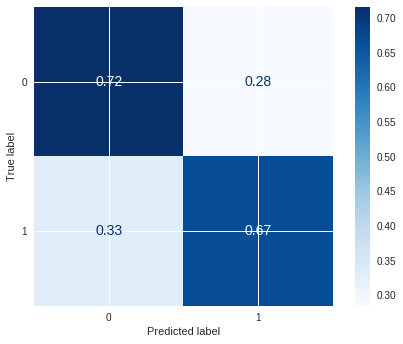

Confusion matrix - test data


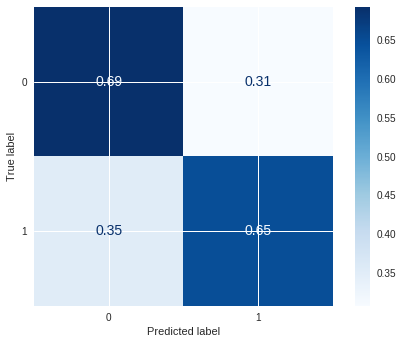

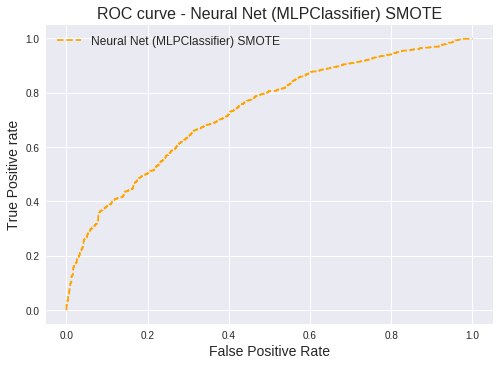

3799 3799
(3799, 2)
kaggle results saved ../data/processed/cazmayhem_nn_mlp_smote.csv


In [740]:
# Test 1 - Neural Net (MLPClassifier) Resampling Imbalance Data - ALL Original Features
random_state = 100
features='ALL'
resample='SMOTE'
model_name=f'Neural Net (MLPClassifier) {resample}'

classifier=clf_NN_MLP

# X_train, y_train, X_val, y_val, X_test, y_test = Prep_Model_Data(df_clean_R1, df_clean_R1_test, target, scaler, classifier, features, model_name, random_state)

X_train_res, y_train_res, X_val_res, y_val_res, X_test_res, y_test_res = Prep_Model_Data(df_clean_R1, target, scaler, resample, random_state)

# run the final Train_Classifier()
classify, X_train_res, y_train_res, X_val_res, y_val_res, X_test_res, y_test_res = Train_Classifier(X_train_res, y_train_res, X_val_res, y_val_res, X_test_res, y_test_res, 
                                                                                                    classifier, features, resample)
# Confusion Matrix Training data
Plot_Confusion_Matrix(classify, X_train_res, y_train_res, 'training data')

# Confusion Matrix Testing data
Plot_Confusion_Matrix(classify, X_test_res, y_test_res, 'test data')

# Plot ROC Curve
pred_prob_1, model_name_1 = Model_Perform_Evaluate(classify, X_test_res, y_test_res, model_name)

# save results for Kaggle comp
Save_Kaggle_Results(classify, scaler, df_clean_R1_test, 'nn_mlp_smote')

Compare accuracy between data sets - testing ALL features 
Classifier - LogisticRegression(C=109.85411419875572, random_state=100)
Imbalanced data fix - SMOTE
Baseline:      0.5
Train data:    0.6605097030628946
Validation:    0.6216981132075472
Test data auc: 0.7301530133737341 

Confusion matrix - training data


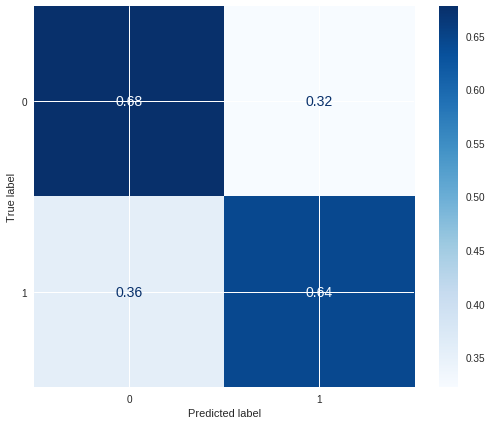

Confusion matrix - test data


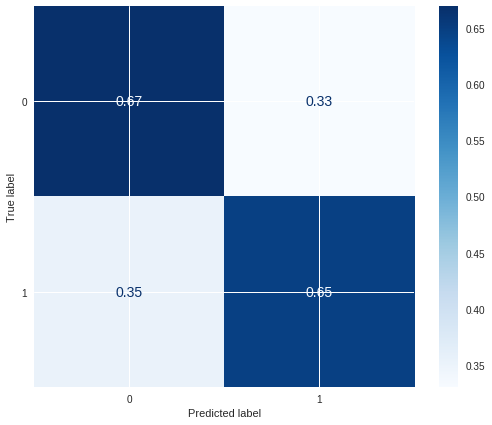

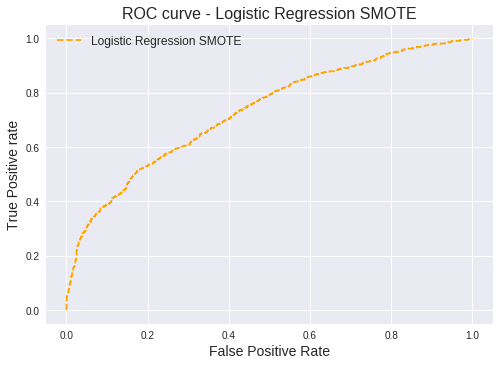

3799 3799
(3799, 2)
kaggle results saved ../data/processed/cazmayhem_lr_smote.csv


In [748]:
# Test 2 - Logistic Regression Resampling Imbalance Data - ALL Original Features
random_state = 100
features='ALL'
resample='SMOTE'
model_name=f'Logistic Regression {resample}'

classifier=clf_LR

# X_train, y_train, X_val, y_val, X_test, y_test = Prep_Model_Data(df_clean_R1, df_clean_R1_test, target, scaler, classifier, features, model_name, random_state)
X_train_res, y_train_res, X_val_res, y_val_res, X_test_res, y_test_res = Prep_Model_Data(df_clean_R1, target, scaler, resample, random_state)

# run the final Train_Classifier()
classify, X_train_res, y_train_res, X_val_res, y_val_res, X_test_res, y_test_res = Train_Classifier(X_train_res, y_train_res, X_val_res, y_val_res, X_test_res, y_test_res, 
                                                                                                    classifier, features, resample)
# Confusion Matrix Training data
Plot_Confusion_Matrix(classify, X_train_res, y_train_res, 'training data')

# Confusion Matrix Testing data
Plot_Confusion_Matrix(classify, X_test_res, y_test_res, 'test data')

# Plot ROC Curve
pred_prob_2, model_name_2 = Model_Perform_Evaluate(classify, X_test_res, y_test_res, model_name)

# save results for Kaggle comp
Save_Kaggle_Results(classify, scaler, df_clean_R1_test, 'lr_smote')

resample NO RESAMPLE
Compare accuracy between data sets - testing ALL features 
Classifier - LogisticRegression(C=109.85411419875572, random_state=100)
Imbalanced data fix - NO RESAMPLE
Baseline:      0.8353515625
Train data:    0.8376953125
Validation:    0.828125
Test data auc: 0.7180006499036351 

Confusion matrix - training data


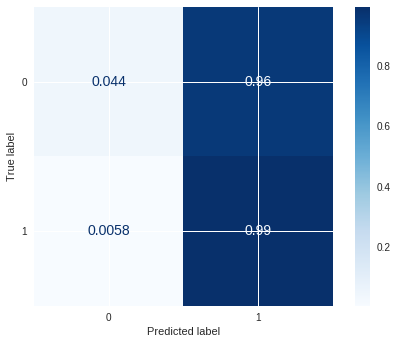

Confusion matrix - test data


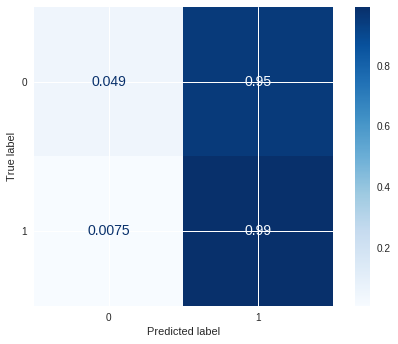

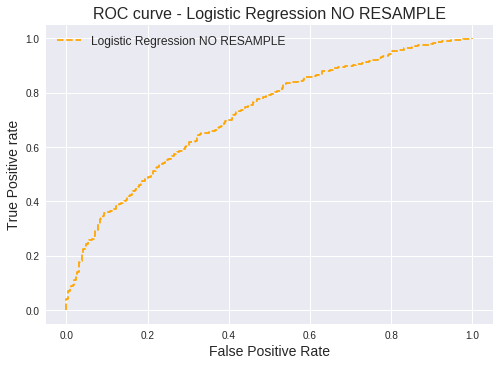

3799 3799
(3799, 2)
kaggle results saved ../data/processed/cazmayhem_lr_no_resample.csv


In [578]:
# Test 3 - Logistic Regression Resampling Imbalance Data - ALL Original Features
random_state = 100
features='ALL'
resample='NO RESAMPLE'
model_name=f'Logistic Regression {resample}'

classifier=clf_LR

# X_train, y_train, X_val, y_val, X_test, y_test = Prep_Model_Data(df_clean_R1, df_clean_R1_test, target, scaler, classifier, features, model_name, random_state)
X_train_res, y_train_res, X_val_res, y_val_res, X_test_res, y_test_res = Prep_Model_Data(df_clean_R1, target, scaler, resample, random_state)

# run the final Train_Classifier()
classify, X_train_res, y_train_res, X_val_res, y_val_res, X_test_res, y_test_res = Train_Classifier(X_train_res, y_train_res, X_val_res, y_val_res, X_test_res, y_test_res, 
                                                                                                    classifier, features, resample)
Save_Kaggle_Results# save results for Kaggle comp
Save_Kaggle_Results(classify, scaler, df_clean_R1_test, 'lr_no_resample')

In [621]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [629]:
%reload_ext autoreload

In [720]:
# Import the xgboost package as xgb
import xgboost as xgb
from src.models.performance import print_class_perf

def Train_XGBoost(xgboost, X_train, y_train, X_val, y_val, X_test, y_test):
    # Fit the model with the prepared data
    xgboost.fit(X_train, y_train)
    print('\n',xgboost.fit(X_train, y_train),'\n')

    # Import dump from joblib and save the fitted model into the folder models as a file called xgboost_default
    from joblib import dump 
    dump(xgboost,  '../models/xgboost_default.joblib')

    # Save the predictions from this model for the training and validation sets into 2 variables called y_train_preds and y_val_preds
    y_train_preds = xgboost.predict(X_train)
    y_val_preds = xgboost.predict(X_val)
    y_test_preds = xgboost.predict(X_test)
    
    # prediction probabilities for AUC
    y_train_pred_prob = xgboost.predict_proba(X_train)
    y_val_pred_prob = xgboost.predict_proba(X_val)
    y_test_pred_prob = xgboost.predict_proba(X_test)

    print_class_perf(y_preds=y_train_preds, y_actuals=y_train, y_pred_prob=y_train_pred_prob[:,1], set_name='Training', average='weighted')
    print_class_perf(y_preds=y_val_preds, y_actuals=y_val, y_pred_prob=y_val_pred_prob[:,1], set_name='Validation', average='weighted')    
    print_class_perf(y_preds=y_test_preds, y_actuals=y_test, y_pred_prob=y_test_pred_prob[:,1], set_name='Test', average='weighted')
    
    return xgboost


In [840]:
def xgb_feature_important(clf_xgb, df_clean, max_num_features=5):
    # Extract the feature importance from the trained xgboost model
    feat_imp = clf_xgb.get_booster().get_score(importance_type="gain")

    # Using a dictionary comprehension, create a dictionary called mapper with keys 
    # in the format of f0 (0 is the index of the first column) and values as column names
    mapper = {'f{0}'.format(i): v for i, v in enumerate(df_clean.columns)}

    # Using a dictionary comprehension, create a dictionary called mapping with keys 
    # as the column names from mapper and values as the corresponding feature importance
    mapping = {mapper[k]: v for k, v in feat_imp.items()}

    # Plot the partial dependence plot using plot_importance for the top 5 features
    xgb.plot_importance(mapping, max_num_features=max_num_features)
    
    # extract top 5 features - but this will be an array
    n_feat = max_num_features
    top_feat = pd.DataFrame(sorted(mapping.items(), key=lambda x: x[1], reverse=True)).iloc[:n_feat,:1].values

    # Convert elements in a numpy array to string
    top_feat = [",".join(item) for item in top_feat.astype(str)]
    print('\n')
    print('Top features list',top_feat)
    
    return top_feat

In [705]:
# Test 3 - Logistic Regression Resampling Imbalance Data - ALL Original Features
random_state = 100
features='ALL'
resample='NO RESAMPLE'
model_name=f'XGBoost {resample}'

# instantiate the XGBClassifier class into a variable called xgboost1
xgboost1 = xgb.XGBClassifier(learning_rate=0.01, random_state=random_state)

X_train_res, y_train_res, X_val_res, y_val_res, X_test_res, y_test_res = Prep_Model_Data(df_clean_R1, target, scaler, resample, random_state)

Train_XGBoost(xgboost1, X_train_res, y_train_res, X_val_res, y_val_res, X_test_res, y_test_res)

NO Resample - ALL Features

 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=100,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None) 

Accuracy Training: 0.85546875
F1       Training: 0.8059690786292248
AUC      Training: 0.812439484999491 

Accuracy Validation: 0.8265625
F1       Validation: 0.7605048802466723
AUC      Validation: 0.6698434819897083 

Accuracy Test: 0.8275
F1       Test: 0.7666689655172415
AUC      Test: 0.7006395387925239 



In [699]:
# Import Trials, STATUS_OK, tpe, hp, fmin from hyperopt package
from hyperopt import Trials, STATUS_OK, tpe, hp, fmin

# Define the search space for xgboost hyperparameters
space = {
    'max_depth' : hp.choice('max_depth', range(5, 20, 1)),
    'learning_rate' : hp.quniform('learning_rate', 0.01, 0.5, 0.05),
    'min_child_weight' : hp.quniform('min_child_weight', 1, 10, 1),
    'subsample' : hp.quniform('subsample', 0.1, 1, 0.05),
    'colsample_bytree' : hp.quniform('colsample_bytree', 0.1, 1.0, 0.05)
}

random_state=100

In [706]:
# Define a function called objective
def objective(space):
    from sklearn.model_selection import cross_val_score
    
    xgboost = xgb.XGBClassifier(
        max_depth = int(space['max_depth']),
        learning_rate = space['learning_rate'],
        min_child_weight = space['min_child_weight'],
        subsample = space['subsample'],
        colsample_bytree = space['colsample_bytree'],
        random_state=random_state
    )
    
    acc = cross_val_score(xgboost, X_train_res, y_train_res, cv=10, scoring="accuracy").mean()

    return{'loss': 1-acc, 'status': STATUS_OK }

In [707]:
# Launch Hyperopt search and save the result in a variable called `best`
best = fmin(
    fn=objective,   
    space=space, 
    algo=tpe.suggest,       
    max_evals=10
)

# Print the best set of hyperparameters
print("\nBest: ", best)

100%|██████████| 10/10 [00:15<00:00,  1.58s/trial, best loss: 0.16738281249999998]

Best:  {'colsample_bytree': 0.45, 'learning_rate': 0.05, 'max_depth': 12, 'min_child_weight': 1.0, 'subsample': 0.2}


In [728]:
# Instantiate a XGBClassifier with best set of hyperparameters
xgboost2 = xgb.XGBClassifier(
    max_depth = best['max_depth'],
    learning_rate = best['learning_rate'],
    min_child_weight = best['min_child_weight'],
    subsample = best['subsample'],
    colsample_bytree = best['colsample_bytree'],
    random_state=random_state
)

# Fit the model with the prepared data
xgboost2.fit(X_train_res, y_train_res)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.45, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=12,
              min_child_weight=1.0, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=100,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.2,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [729]:
# Display the accuracy and f1 scores of this baseline model on the training and validation sets
print_class_perf(y_preds=xgboost2.predict(X_train_res), y_actuals=y_train_res, y_pred_prob=xgboost2.predict_proba(X_train_res)[:,1], set_name='Training', average='weighted')
print_class_perf(y_preds=xgboost2.predict(X_val_res), y_actuals=y_val_res, y_pred_prob=xgboost2.predict_proba(X_val_res)[:,1], set_name='Validation', average='weighted')
print_class_perf(y_preds=xgboost2.predict(X_test_res), y_actuals=y_test_res, y_pred_prob=xgboost2.predict_proba(X_test_res)[:,1], set_name='Test', average='weighted')

Accuracy Training: 0.944587327566051
F1       Training: 0.9445077145384019
AUC      Training: 0.9913706150678776 

Accuracy Validation: 0.8400943396226415
F1       Validation: 0.8382726398163725
AUC      Validation: 0.9018859024563902 

Accuracy Test: 0.8464714714714715
F1       Test: 0.8450291977623747
AUC      Test: 0.9087358755151547 



In [815]:
features='Reduced'
resample='SMOTE'
scaler = StandardScaler()

df_clean = df_clean_R2.copy()

X_train_res, y_train_res, X_val_res, y_val_res, X_test_res, y_test_res = Prep_Model_Data(df_clean, target, scaler, resample, random_state)

Train_XGBoost(xgboost2, X_train_res, y_train_res, X_val_res, y_val_res, X_test_res, y_test_res)


 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.45, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=12,
              min_child_weight=1.0, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=100,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.2,
              tree_method='exact', validate_parameters=1, verbosity=None) 

Accuracy Training: 0.9387421089548749
F1       Training: 0.9386092071452082
AUC      Training: 0.9899385433414554 

Accuracy Validation: 0.8391509433962264
F1       Validation: 0.8370095173978338
AUC      Validation: 0.9027830188679246 

Accuracy Test: 0.847972972972973
F1       Test: 0.8462870001731004
AUC      Test: 0.9052909891873855 



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.45, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=12,
              min_child_weight=1.0, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=100,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.2,
              tree_method='exact', validate_parameters=1, verbosity=None)


 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.45, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=12,
              min_child_weight=1.0, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=100,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.2,
              tree_method='exact', validate_parameters=1, verbosity=None) 

Accuracy Training: 0.944587327566051
F1       Training: 0.9445077145384019
AUC      Training: 0.9913706150678776 

Accuracy Validation: 0.8400943396226415
F1       Validation: 0.8382726398163725
AUC      Validation: 0.9018859024563902 

Accuracy Test: 0.8464714714714715
F1       Test: 0.8450291977623747
AUC      Test: 0.9087358755151547 

Confusion matrix - training data


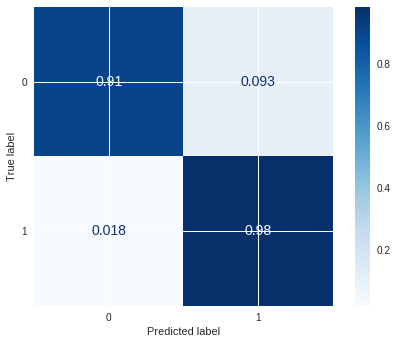

Confusion matrix - test data


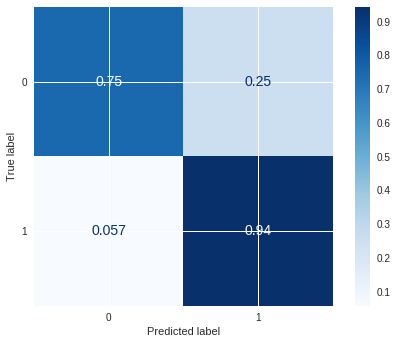

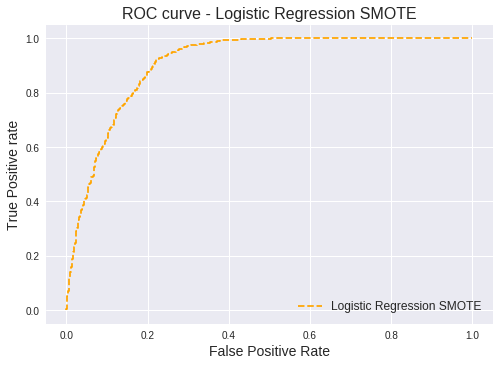

3799 3799
(3799, 2)
kaggle results saved ../data/processed/cazmayhem_xgboost_smote.csv


Top features list ['BLK', 'GP', 'STL', 'TOV', 'FTM']


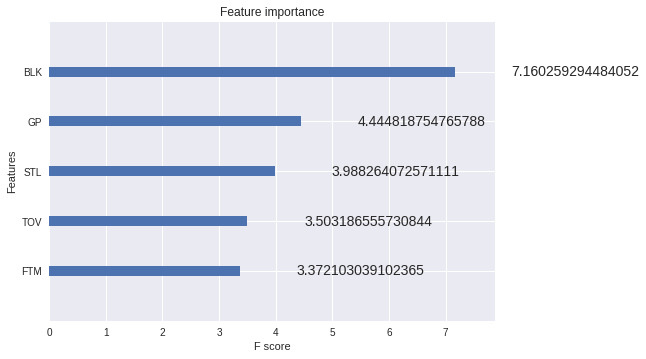

In [816]:
features='ALL'
resample='SMOTE'
scaler = StandardScaler()

df_clean_mod = df_clean_R1.copy()
df_clean_mod_test = df_clean_R1_test.copy()

# Prep model data - scale, train_test_split, resample if specified - return the sampled Training, Validation & Test data
X_train_res, y_train_res, X_val_res, y_val_res, X_test_res, y_test_res = Prep_Model_Data(df_clean_mod, target, scaler, resample, random_state)

# Train the model using xgboost2 after hyperopt
classify = Train_XGBoost(xgboost2, X_train_res, y_train_res, X_val_res, y_val_res, X_test_res, y_test_res)

# Confusion Matrix Training data
Plot_Confusion_Matrix(classify, X_train_res, y_train_res, 'training data')

# Confusion Matrix Testing data
Plot_Confusion_Matrix(classify, X_test_res, y_test_res, 'test data')

# Plot ROC Curve - save pret_prob & model_name for combined ROC graph
pred_prob_3, model_name_3 = Model_Perform_Evaluate(classify, X_test_res, y_test_res, model_name)

# save results for Kaggle comp - XGBoost with hyperopt using SMOTE for imbalanced target - correct model this time
Save_Kaggle_Results(classify, scaler, df_clean_mod_test, 'xgboost_smote')

# Show XGB feature importance
xgb_feature_important(classify, df_clean_mod, max_num_features=5)

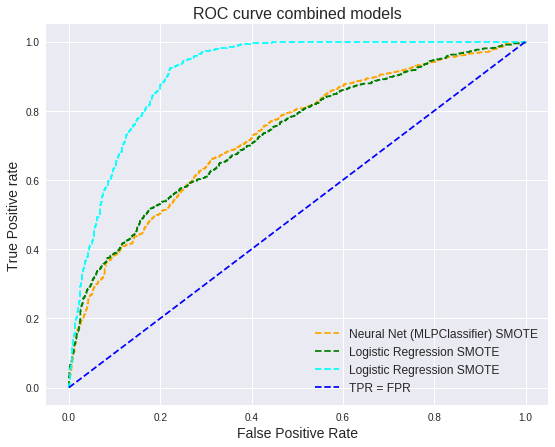

In [817]:
#=========================================================================
# COMBINE ROC CURVE GRAPH
#=========================================================================

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_test_res, pred_prob_1[:,1], pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_test_res, pred_prob_2[:,1], pos_label=1)
fpr3, tpr3, thresh3 = roc_curve(y_test_res, pred_prob_3[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

# chart size
plt.rcParams["figure.figsize"] = (9,7) 

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label=model_name_1)
plt.plot(fpr2, tpr2, linestyle='--',color='green', label=model_name_2)
plt.plot(fpr3, tpr3, linestyle='--',color='cyan', label=model_name_3)
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue', label='TPR = FPR')

# title
plt.title(f'ROC curve combined models', fontsize=font_size+2)
# x label
plt.xlabel('False Positive Rate', fontsize=font_size)
# y label
plt.ylabel('True Positive rate', fontsize=font_size)

plt.legend(loc='best', fontsize=(font_size-2))
plt.savefig('ROC',dpi=300)
plt.show();    


 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.45, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=12,
              min_child_weight=1.0, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=100,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.2,
              tree_method='exact', validate_parameters=1, verbosity=None) 

Accuracy Training: 0.944587327566051
F1       Training: 0.9445077145384019
AUC      Training: 0.9913706150678776 

Accuracy Validation: 0.8400943396226415
F1       Validation: 0.8382726398163725
AUC      Validation: 0.9018859024563902 

Accuracy Test: 0.8464714714714715
F1       Test: 0.8450291977623747
AUC      Test: 0.9087358755151547 

Confusion matrix - training data


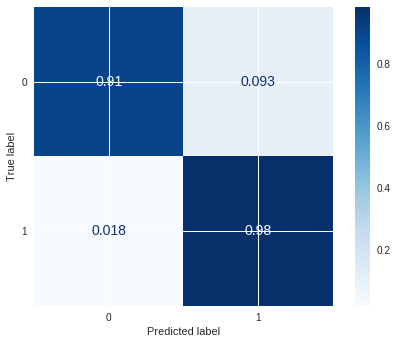

Confusion matrix - test data


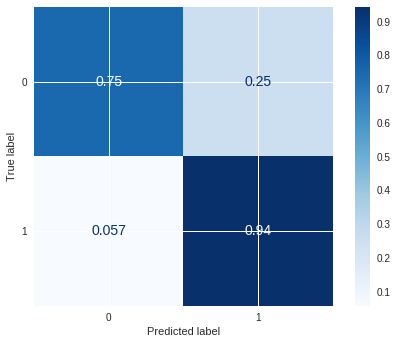

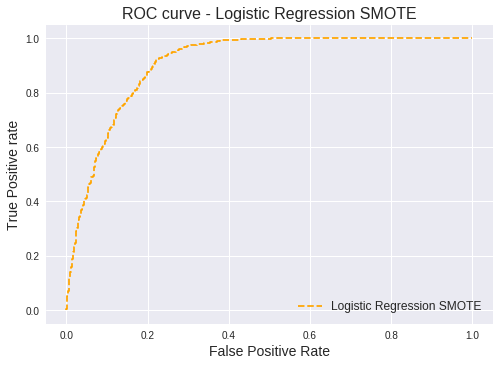

3799 3799
(3799, 2)
kaggle results saved ../data/processed/cazmayhem_xgboost_smote.csv


Top features list ['BLK', 'GP', 'STL', 'TOV', 'FTM', 'OREB']


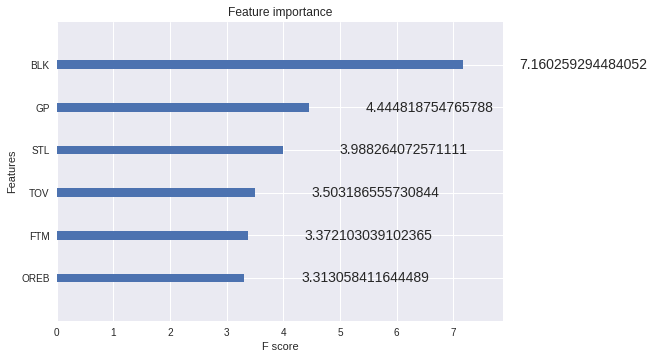

In [846]:
features='ALL'
resample='SMOTE'
scaler = StandardScaler()
max_num_features=6
# labels = ALL original features
top_feat=labels

# select required features for this tesm
df_clean_mod, df_clean_mod_test = select_features(df_cleaned, df_clean_test, top_feat)
 
# Prep model data - scale, train_test_split, resample if specified - return the sampled Training, Validation & Test data
X_train_res, y_train_res, X_val_res, y_val_res, X_test_res, y_test_res = Prep_Model_Data(df_clean_mod, target, scaler, resample, random_state)

# Train the model using xgboost2 after hyperopt
classify = Train_XGBoost(xgboost2, X_train_res, y_train_res, X_val_res, y_val_res, X_test_res, y_test_res)

# Confusion Matrix Training data
Plot_Confusion_Matrix(classify, X_train_res, y_train_res, 'training data')

# Confusion Matrix Testing data
Plot_Confusion_Matrix(classify, X_test_res, y_test_res, 'test data')

# Plot ROC Curve - save pret_prob & model_name for combined ROC graph
pred_prob_4, model_name_4 = Model_Perform_Evaluate(classify, X_test_res, y_test_res, model_name)

# save results for Kaggle comp - XGBoost with hyperopt using SMOTE for imbalanced target - correct model this time
Save_Kaggle_Results(classify, scaler, df_clean_mod_test, 'xgboost_smote')

# Show XGB feature importance
top_feat = xgb_feature_important(classify, df_clean_mod, max_num_features)


 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.45, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=12,
              min_child_weight=1.0, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=100,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.2,
              tree_method='exact', validate_parameters=1, verbosity=None) 

Accuracy Training: 0.9076455459434183
F1       Training: 0.9070890727072421
AUC      Training: 0.9679924466163579 

Accuracy Validation: 0.8731132075471698
F1       Validation: 0.8717191696252372
AUC      Validation: 0.9169268422926309 

Accuracy Test: 0.887012012012012
F1       Test: 0.8861856309259688
AUC      Test: 0.9330191678164652 

Confusion matrix - training data


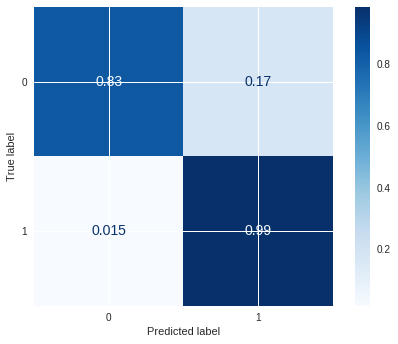

Confusion matrix - test data


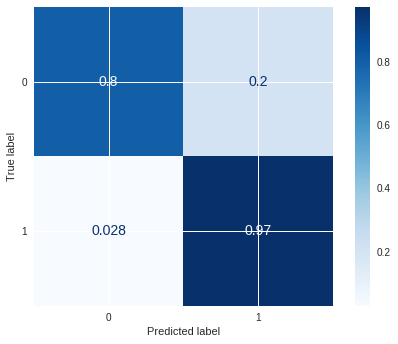

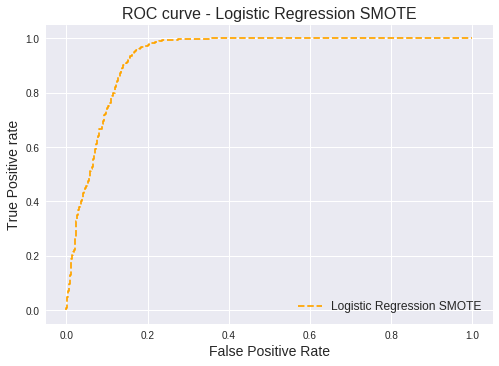

3799 3799
(3799, 2)
kaggle results saved ../data/processed/cazmayhem_xgboost_smote.csv


In [848]:
features='ALL'
resample='SMOTE'
scaler = StandardScaler()
top_feat=top_feat

scaler = StandardScaler()

# select required features for this tesm
df_clean_mod, df_clean_mod_test = select_features(df_cleaned, df_clean_test, top_feat)
 
# intiailse training data for this test
X_train_res, y_train_res, X_val_res, y_val_res, X_test_res, y_test_res = Prep_Model_Data(df_clean_mod, target, scaler, resample, random_state)

# Prep model data - scale, train_test_split, resample if specified - return the sampled Training, Validation & Test data
X_train_res, y_train_res, X_val_res, y_val_res, X_test_res, y_test_res = Prep_Model_Data(df_clean_mod, target, scaler, resample, random_state)

# Train the model using xgboost2 after hyperopt
classify = Train_XGBoost(xgboost2, X_train_res, y_train_res, X_val_res, y_val_res, X_test_res, y_test_res)

# Confusion Matrix Training data
Plot_Confusion_Matrix(classify, X_train_res, y_train_res, 'training data')

# Confusion Matrix Testing data
Plot_Confusion_Matrix(classify, X_test_res, y_test_res, 'test data')

# Plot ROC Curve - save pret_prob & model_name for combined ROC graph
pred_prob_4, model_name_4 = Model_Perform_Evaluate(classify, X_test_res, y_test_res, model_name)

# save results for Kaggle comp - XGBoost with hyperopt using SMOTE for imbalanced target - correct model this time
Save_Kaggle_Results(classify, scaler, df_clean_mod_test, 'xgboost_smote')

# Show XGB feature importance
# top_feat = xgb_feature_important(classify, df_clean_mod, top_feat)


 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.45, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=12,
              min_child_weight=1.0, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=100,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.2,
              tree_method='exact', validate_parameters=1, verbosity=None) 

Accuracy Training: 0.9076455459434183
F1       Training: 0.9070890727072421
AUC      Training: 0.9679924466163579 

Accuracy Validation: 0.8731132075471698
F1       Validation: 0.8717191696252372
AUC      Validation: 0.9169268422926309 

Accuracy Test: 0.887012012012012
F1       Test: 0.8861856309259688
AUC      Test: 0.9330191678164652 

Confusion matrix - training data


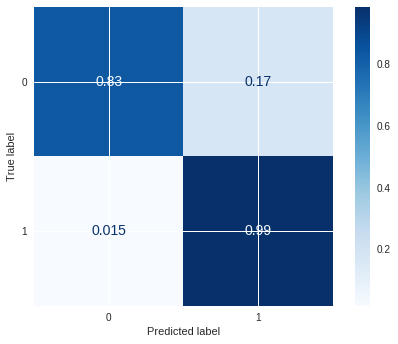

Confusion matrix - test data


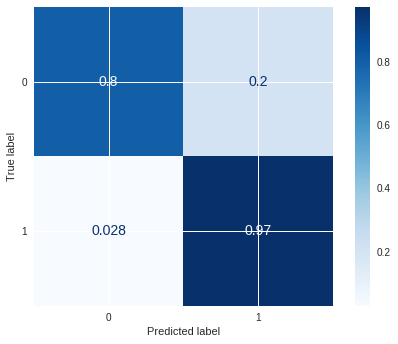

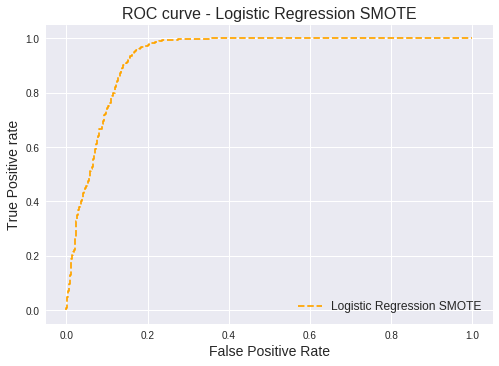

3799 3799
(3799, 2)
kaggle results saved ../data/processed/cazmayhem_xgboost_smote_test.csv


Top features list ['BLK', 'TOV', 'OREB', 'GP', 'FTM']


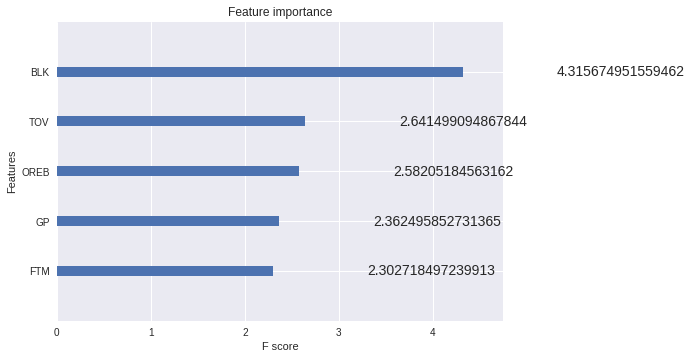

In [850]:
# rerun model with top N features from previous step
top_feat

features='ALL'
resample='SMOTE'
scaler = StandardScaler()

#df_clean_mod = df_clean_R2.copy()
#df_clean_mod_test = df_clean_R2_test.copy()

# create train/test data from selected important features only
df_clean_mod, df_clean_mod_test = select_features(df_clean_R2, df_clean_R2_test, top_feat)

# Prep model data - scale, train_test_split, resample if specified - return the sampled Training, Validation & Test data
X_train_res, y_train_res, X_val_res, y_val_res, X_test_res, y_test_res = Prep_Model_Data(df_clean_mod, target, scaler, resample, random_state)

# Train the model using xgboost2 after hyperopt
classify = Train_XGBoost(xgboost2, X_train_res, y_train_res, X_val_res, y_val_res, X_test_res, y_test_res)

# Confusion Matrix Training data
Plot_Confusion_Matrix(classify, X_train_res, y_train_res, 'training data')

# Confusion Matrix Testing data
Plot_Confusion_Matrix(classify, X_test_res, y_test_res, 'test data')

# Plot ROC Curve - save pret_prob & model_name for combined ROC graph
pred_prob_4, model_name_4 = Model_Perform_Evaluate(classify, X_test_res, y_test_res, model_name)

# save results for Kaggle comp - XGBoost with hyperopt using SMOTE for imbalanced target - correct model this time
Save_Kaggle_Results(classify, scaler, df_clean_mod_test, 'xgboost_smote_test')

# Show XGB feature importance
top_feat = xgb_feature_important(classify, df_clean_mod, max_num_features=5)

In [769]:
['BLK','STL','GP','FTM','3P Made']
# Xgboost Variable Importance by Permutation
from sklearn.inspection import permutation_importance

# Calculate variable importance by permutation on the training set
r = permutation_importance(
    clf_xgb, X_train_res, y_train_res,
    n_repeats=30,
    random_state=8
)

# Sort the variable importance, iterate through the features and print their values
for i in r.importances_mean.argsort()[::-1]:
     print(f"{df_clean_R2.columns[i]}: {r.importances_mean[i]:.5f}")

BLK: 0.04991
GP: 0.02771
STL: 0.02540
TOV: 0.01667
FGA: 0.01511
FTM: 0.01469
OREB: 0.01417
FGM: 0.01379
FTA: 0.01224
MIN: 0.01212
DREB: 0.01127
AST: 0.01111
3PA: 0.00993
REB: 0.00930
3P Made: 0.00888
PTS: 0.00883


In [770]:
# Partial Dependence Plot
from sklearn.inspection import plot_partial_dependence

def plot_pdp(model, X, feature_name, feature_cols, target_classes):
    feature_index = feature_cols.get_loc(feature_name)
    
    print(f"PDP for `{feature_cols[feature_index]}` ({feature_index}) with {target_classes}")
    
    for target_class in target_classes:
        plot_partial_dependence(model, X, features=[feature_index], target=target_class)

In [775]:
# Create a list called target_classes contating the list of all values from the target variable
target_classes=['x<5min', 'x<10min', 'x<30min', 'x>=30min']

# Display the partial dependence plot for the payment_type feature on the training set with plot_pdp function
# plot_pdp(model=clf_xgb, X=X_train_res, feature_name='TARGET_5Yrs', feature_cols=df_cleaned.columns, target_classes=target_classes)


In [ ]:
# Import LimeTabularExplainer from lime.lime_tabular
from lime.lime_tabular import LimeTabularExplainer

# Create a LimeTabularExplainer with the training set and save it into a variable called lime_explainer
lime_explainer = LimeTabularExplainer(X_train,
      feature_names=df_cleaned.columns,
      class_names=target_classes,
      mode='classification',
      discretize_continuous=False
)

# Analyse the first observation from the testing set with lime_explainer for the top value of the target variable
exp = lime_explainer.explain_instance(
    X_test[0], 
    xgboost2.predict_proba, 
    top_labels=1,
    num_features=20)

# Display the results with show_in_notebook
exp.show_in_notebook()

In [ ]:
# Test 2 - Neural Net (MLPClassifier) Resampling Imbalance Data - ALL Original Features
random_state = 100
features='partial'
resample='NO RESAMPLE'
model_name=f'Logistic Regression {resample}'

X_train, y_train, X_val, y_val, X_test, y_test = Train_Model(df_clean_R2, df_clean_R2_test, target, scaler, clf_LR, 
                                                             features, model_name, random_state)

# NO RESAMPLING
classify, X_train_res, y_train_res, X_test_res, y_test_res = Train_Model_Resample(resample, X_train, y_train, X_val, y_val, X_test, y_test, clf_LR, features, model_name, random_state)

# Confusion Matrix Training data
Plot_Confusion_Matrix(classify, X_train_res, y_train_res, 'training data')

# Confusion Matrix Testing data
Plot_Confusion_Matrix(classify, X_test_res, y_test_res, 'test data')

Model_Perform_Evaluate(classify, X_test_res, y_test_res, model_name)


In [290]:
# Test 1 - Neural Net (MLPClassifier) Resampling Imbalance Data - ALL Original Features

features='all'
batch_size=100
random_state=100

clf_NN_MLP=MLPClassifier(activation=activation, solver=solver, alpha=alpha, batch_size=batch_size, random_state=random_state)

Train_Model(df_clean_R1, df_clean_R1_test, target, scaler, clf_NN_MLP, features, random_state)

Compare accuracy between data sets - testing all features 
Classifier - MLPClassifier(activation='logistic', alpha=0.01, batch_size=100,
              random_state=100)
Imbalanced data fix - NO RESAMPLE
Baseline:      0.8353515625
Train data:    0.8369140625
Validation:    0.82734375
Test data auc: 0.7153646183496929 

Compare accuracy between data sets - testing all features 
Classifier - MLPClassifier(activation='logistic', alpha=0.01, batch_size=100,
              random_state=100)
Imbalanced data fix - SMOTE
Baseline:      0.5
Train data:    0.6905541267243395
Validation:    0.6117924528301887
Test data auc: 0.7309956352749146 

Compare accuracy between data sets - testing all features 
Classifier - MLPClassifier(activation='logistic', alpha=0.01, batch_size=100,
              random_state=100)
Imbalanced data fix - ADASYN
Baseline:      0.5080175792849507
Train data:    0.6633804489844399
Validation:    0.6215469613259669
Test data auc: 0.7099637216330255 



In [298]:
clf_LR=LogisticRegression(C=109.85411419875572, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100, n_jobs=None, penalty='l2',
          tol=0.0001, verbose=0, warm_start=False, random_state=random_state)

features='all'
random_state=100

Train_Model(df_clean_R1, df_clean_R1_test, target, scaler, clf_LR, features, random_state)

Compare accuracy between data sets - testing all features 
Classifier - LogisticRegression(C=109.85411419875572, random_state=100)
Imbalanced data fix - NO RESAMPLE
Baseline:      0.8353515625
Train data:    0.8376953125
Validation:    0.828125
Test data auc: 0.7180006499036351 

Compare accuracy between data sets - testing all features 
Classifier - LogisticRegression(C=109.85411419875572, random_state=100)
Imbalanced data fix - SMOTE
Baseline:      0.5
Train data:    0.6605097030628946
Validation:    0.6216981132075472
Test data auc: 0.7301530133737341 

Compare accuracy between data sets - testing all features 
Classifier - LogisticRegression(C=109.85411419875572, random_state=100)
Imbalanced data fix - ADASYN
Baseline:      0.5080175792849507
Train data:    0.639624658510512
Validation:    0.6187845303867403
Test data auc: 0.7037587429201353 



In [322]:
# Test 2 - Logistic Regression - Resampling Imbalance Data - ALL Original Features

features='all'

Train_Model_Select(df_clean_R1, df_clean_R1_test, target, scaler, clf_LR, features, random_state)

X_train    (5120, 19)
X_new      (5120, 8)   ::  X_val_new  (5120, 8)   ::  X_test_new (5120, 8) 

Compare accuracy between data sets - testing all features 
Classifier - LogisticRegression(C=109.85411419875572, random_state=100)
Imbalanced data fix - NO RESAMPLE
Baseline:      0.8353515625
Train data:    0.83671875
Validation:    0.8296875
Test data auc: 0.7066161310564296 

Compare accuracy between data sets - testing all features 
Classifier - LogisticRegression(C=109.85411419875572, random_state=100)
Imbalanced data fix - SMOTE
Baseline:      0.5
Train data:    0.6571194762684124
Validation:    0.6268867924528302
Test data auc: 0.7057857406956506 

Compare accuracy between data sets - testing all features 
Classifier - LogisticRegression(C=109.85411419875572, random_state=100)
Imbalanced data fix - ADASYN
Baseline:      0.5098950882212685
Train data:    0.639723414401526
Validation:    0.6123287671232877
Test data auc: 0.6878154750495176 



In [326]:
from sklearn.feature_selection import SelectFromModel

def Train_Model_Select(df_clean, df_clean_test, target, scaler, classify, features, random_state=8):

    # rescale eg: scaler = StandardScaler()
    df_clean = scaler.fit_transform(df_clean_test)
    df_clean_test = scaler.fit_transform(df_clean_test)

    #---------------------------------------------------------------------------------------
    # Split randomly the dataset with random_state=8 into 2 different sets: data (80%) and test (20%)
    X_data, X_test, y_data, y_test = train_test_split (df_clean, target, test_size=0.2, random_state=random_state)

    # Split the remaining data (80%) randomly with random_state=8 into 2 different sets: training (80%) and validation (20%)
    X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=random_state) 
    
    #---------------------------------------------------------------------------------------
    # SelectFromModel - meta-transformer for selecting features based on importance weights.
    model = SelectFromModel(estimator=classify).fit(X_train, y_train)

    X_new = model.transform(X_train)
    X_val_new = model.transform(X_val)
    X_test_new = model.transform(X_test)
    
    print('X_train   ',X_train.shape)
    print('X_new     ',X_new.shape, '  ::  X_val_new ',X_new.shape, '  ::  X_test_new',X_new.shape,'\n')
    
    # Train_MLP_Classifier(X_new, y_train, X_val_new, y_val, X_test_new, y_test, classify, 'all', 'NO RESAMPLE')

    #---------------------------------------------------------------------------------------
    # NO RESAMPLING
    Train_Model_Resample('NO RESAMPLE', X_new, y_train, X_val_new, y_val, X_test_new, y_test, classify, features=features)

    # SMOTE - treat Imbalanced Target data after splitting Training & Test & Validation data
    Train_Model_Resample('SMOTE', X_new, y_train, X_val_new, y_val, X_test_new, y_test, classify, features=features)
        
    # ADASYN - treat Imbalanced Target data after splitting Training & Test & Validation data
    Train_Model_Resample('ADASYN', X_new, y_train, X_val_new, y_val, X_test_new, y_test, classify, features=features)
    

In [328]:
# Test 2 - Logistic Regression - Resampling Imbalance Data - ALL Original Features

features='all'

Train_Model_Select(df_clean_R1, df_clean_R1_test, target, scaler, clf_LR, features, random_state)

X_train    (5120, 19)
X_new      (5120, 8)   ::  X_val_new  (5120, 8)   ::  X_test_new (5120, 8) 

Compare accuracy between data sets - testing all features 
Classifier - LogisticRegression(C=109.85411419875572, random_state=100)
Imbalanced data fix - NO RESAMPLE
Baseline:      0.8353515625
Train data:    0.83671875
Validation:    0.8296875
Test data auc: 0.7066161310564296 

Compare accuracy between data sets - testing all features 
Classifier - LogisticRegression(C=109.85411419875572, random_state=100)
Imbalanced data fix - SMOTE
Baseline:      0.5
Train data:    0.6571194762684124
Validation:    0.6268867924528302
Test data auc: 0.7057857406956506 

Compare accuracy between data sets - testing all features 
Classifier - LogisticRegression(C=109.85411419875572, random_state=100)
Imbalanced data fix - ADASYN
Baseline:      0.5098950882212685
Train data:    0.639723414401526
Validation:    0.6123287671232877
Test data auc: 0.6878154750495176 



In [344]:
# Test 1 - Neural Net (MLPClassifier) Resampling Imbalance Data - ALL Original Features

random_state=100

clf_NN_MLP=MLPClassifier(activation=activation, solver=solver, alpha=alpha, batch_size=batch_size, random_state=random_state)

Train_Model(df_clean_R2, df_clean_R2_test, target, scaler, clf_NN_MLP, 'partial', random_state)

Compare accuracy between data sets - testing partial features 
Classifier - MLPClassifier(activation='logistic', alpha=0.01, batch_size=100,
              random_state=100)
Imbalanced data fix - NO RESAMPLE
Baseline:      0.8353515625
Train data:    0.8369140625
Validation:    0.82890625
Test data auc: 0.7068850566984897 

Compare accuracy between data sets - testing partial features 
Classifier - MLPClassifier(activation='logistic', alpha=0.01, batch_size=100,
              random_state=100)
Imbalanced data fix - SMOTE
Baseline:      0.5
Train data:    0.6568856675239654
Validation:    0.6320754716981132
Test data auc: 0.7215221978735492 

Compare accuracy between data sets - testing partial features 
Classifier - MLPClassifier(activation='logistic', alpha=0.01, batch_size=100,
              random_state=100)
Imbalanced data fix - ADASYN
Baseline:      0.5099558841063551
Train data:    0.6444497436508883
Validation:    0.6248860528714676
Test data auc: 0.6919111054182145 



Compare accuracy between data sets - testing partial features 
Classifier - LogisticRegression(C=110, l1_ratio=0.4, max_iter=8000, penalty='elasticnet',
                   random_state=100, solver='saga')
Imbalanced data fix - NO RESAMPLE
Baseline:      0.8353515625
Train data:    0.8369140625
Validation:    0.828125
Test data auc: 0.7137930841289051 

auc_score 0.7137930841289051
Compare accuracy between data sets - testing partial features 
Classifier - LogisticRegression(C=110, l1_ratio=0.4, max_iter=8000, penalty='elasticnet',
                   random_state=100, solver='saga')
Imbalanced data fix - SMOTE
Baseline:      0.5
Train data:    0.6584054243628712
Validation:    0.6273584905660378
Test data auc: 0.7243239861483105 

auc_score 0.7243239861483105
Compare accuracy between data sets - testing partial features 
Classifier - LogisticRegression(C=110, l1_ratio=0.4, max_iter=8000, penalty='elasticnet',
                   random_state=100, solver='saga')
Imbalanced data fix - ADAS

In [396]:
#--------------------------------------------------------------------------
# Save the fitted model into the folder 'models', named for each classifier
rerun_no=1
dump(clf_LR,  '../models/r{d}_{c}.joblib'.format(d=rerun_no, c="LR_SMOTE"))

['../models/r1_LR_SMOTE.joblib']